In [14]:
#GAMZE MADEN
#504202514
#########################
import numpy as np
import matplotlib.pyplot as plt
# Python language software package for the creation, manipulation, and study of the structure, dynamics, and function of complex networks
from networkx import nx, gnm_random_graph, gnp_random_graph, erdos_renyi_graph 
import networkx.algorithms.community as nx_comm
from networkx.algorithms.smallworld import random_reference
import random
import community 
from numpy import linalg as LA
from tqdm import tqdm
import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy.io

# QUESTION (1.1) Explain the key steps of Bellman-Ford algorithm (one-by-one). [5%]

function BellmanFord(G, start_ID)
Input: Graph and start_ID 
Output: Array of Nodes, Shortest distance to all vertices from node with start_ID, Previous node from current node. If there is a negative weight cycle, then shortest distances are not calculated, negative weight cycle is reported.

1)Initialize the distance to all nodes to infinity except start_ID which is 0 and array to store previous node


    distance := list of size n
    predecessor := list of size n
    
2)Relaxation step which means approximation of difficult problem using easier one to solve. BellmanFord relaxes all edges (V-1 in V is node count) not only neighbors which makes differentiates it from Dijkstra's. It calculates shorter paths until finding the shortest one from starting node. Also in this step previous nodes stored in array named predecessor. 
    
    repeat |V|−1 times:
         for each edge (u, v) with weight w in edges do
             if distance[u] + w < distance[v] then
                 distance[v] := distance[u] + w
                 predecessor[v] := u


3)Check for negative-weight cycles and report if exists. Here we calculate shortest distance for all nodes one more time and if it finds shorter path than above loop did, means graph has negative cycle. 

      for each edge (u, v) with weight w in edges do
        if distance[u] + w < distance[v] then
            error "Graph contains a negative-weight cycle"
            
4)Return shortest distance and array of which contains previous shortest distanced nodes for each vertex
       
       return distance, predecessor 
 

# QUESTION (1.2) Write a function called BellmanFordAlgo that takes (i) A and (2) astarting node ID as inputs, and outputs an array as in Graph Theory Blink 5.4 a , where each row represents a node in the graph G and comprising three columns (nodes, shortest distance from source input node, previous node). [10%] Use of external libraries is not allowed. Code it up from scratch.

In [2]:
#Implementing Bellman-Ford's Algorithm
def BellmanFordAlgo(A, start_ID):
    #create graph from adjacency matrix
    graph_ = nx.from_numpy_matrix(A,create_using=nx.DiGraph)
    #assign number of nodes to V
    V=graph_.number_of_nodes()
    #initialize dictionary to INFINITE for all nodes except start_ID 
    dist = {i : float("Inf") for i in graph_.nodes}
    #set starting node distance to 0
    dist[start_ID] = 0
    #store previous node from current node which has the shortest distance
    previous_node = [0] * V
    
    #loop for edge count which is (node count-1)
    for temp in range(V-1):
        #inner loop for source node u, target node v and weight between them
        for u, v, w in graph_.edges(data=True):
            #get weight value since w returns dictionary
            a=w["weight"]
            #calculate shortest distance
            if dist[u] != float("Inf")  and dist[u] + a< dist[v]:
                #store distance value for current u and v
                dist[v] = dist[u] + a        
                #store previous node with shortest distance in array
                previous_node[v] = u
                
    #check for negative cycle by looping over all nodes one more time            
    for u, v, w in graph_.edges(data=True):
        a=w["weight"]
        if dist[u] != float("Inf")  and dist[u] + a< dist[v]:
            #report if exists negative cycle
            print("Graph contains negative cycle")
            #exit process
            return
    #print required array in HW 
    print("Node\t\tDistance\tPrevious node")
    for key, value in dist.items(): 
        print("{0}\t\t{1}\t\t{2}".format(key, value,previous_node[key]))  
  

# QUESTION (1.3) Run your function in the Jupyter Notebook on the input adjacency matrix A (see Fig. fig:1) and display the output array. You can find the data inside ‘Exercise 1 data’ folder. [5%]

In [3]:
#get adjacency matrix of HW
mat = scipy.io.loadmat('adjacencyMatrix.mat')
#extract only matrix from mat file whose field name is A 
adjacencyMatrix=mat['A']   
#call function and output reqired array in HW
BellmanFordAlgo(adjacencyMatrix,0)

Node		Distance	Previous node
0		0		0
1		1		0
2		2		0
3		5		1
4		8		3
5		5		2


# QUESTION (2.1) Write a function globalEfficiency, which inputs a graph adjacency matrix A and outputs the global efficiency value. [5%]

In [4]:
def globalEfficiency(A):
    glob_eff=0.0
    #create graph from adjacency matrix
    G = nx.from_numpy_matrix(A)
    #assign number of nodes to N
    N=G.number_of_nodes()
    length = dict(nx.all_pairs_dijkstra_path_length(G))
    sigma_=0.0
    for node in G.nodes:
        for inner_node in G.nodes:
            if length[node][inner_node]!=0:
                sigma_+=1/length[node][inner_node]

        
    
    glob_eff = (1/(N*(N-1)))*sigma_
    
    print("E_glob= {0}\t\t".format(glob_eff))
    return glob_eff
    
    

# QUESTION (2.2) Write a function diffusionEfficiency, which inputs a graph adjacency matrix A and outputs the diffusion efficiency value. [5%]

In [5]:
#calculate strength (from previous Homework)
def degree_centrality(G):
    return dict(G.degree(weight = "weight"))

In [86]:
def diffusionEfficiency(A):
    diff_eff=0.0
    #create graph from adjacency matrix
    G = nx.from_numpy_matrix(A)
    #calculate strength of each node
    dict_strength=degree_centrality(G)
    #get only strength values from dictionary object as a list
    values = list(dict_strength.values())
    #cast list to numpy array
    an_array = np.array(values)
    #get node count
    N=G.number_of_nodes()
    #Initialize S matrix NxN 
    S= np.zeros((N, N), float)
    #Diagonally fill matrix S with strength values elements of array
    np.fill_diagonal(S, an_array)
    #I changed variable name to better show formula U=WS**-1
    W=A
    # This will return matrix product of two array
    U = W @ np.linalg.inv(S)
    #create I matrix
    I= np.zeros((N, N), float)
    np.fill_diagonal(I, 1)
    #Initialize sigma 
    Xij=np.zeros((N, N), float)
    for n in range(N):
        for i in range(N):
            if i!=n:
                #sum (n,i) elements of U over all nodes where i != j 
                Xij=np.add(Xij, np.linalg.inv(np.subtract(I, U[n][i])))
                
    sigma_=0
    for n in range(N):
        for i in range(N):
            sigma_ += 1/Xij[n][i]
            
    diff_eff = (1/(N*(N-1)))*sigma_
    print("E_diff= {0}\t\t".format(diff_eff))
    return diff_eff

# QUESTION (2.3) Create a scatter plot where x-axis represents threshold value α ∈ [0 : 0.1 : 0.9] (0.1 denotes the threshold step size) and the y-axis represents the global efficiency E glob of brain graph adjacency matrices ‘Exercise 2 data/ brainGraph1.mat’ and ‘Exercise 2 data/ brainGraph2.mat’ (Fig. fig:2). By thresholding each adjacency matrix at different threshold values α ∈ [0 : 0.1 : 0.9], examine how its global and diffusion efficiencies change. Use two different colors to compare the change in global efficiency across both brain graphs. [5%]

E_glob= 6.174287370678654		
E_diff= -0.05745376227109758		
E_glob= 13.349421728782737		
E_diff= 0.01204897909449197		
E_glob= 21.51514200050434		
E_diff= -0.31972702112920753		
E_glob= 30.80642225595913		
E_diff= -0.019757518495498227		
E_glob= 36.06626909271474		
E_diff= -0.0013156143216982768		
E_glob= 35.32783792673426		
E_diff= -0.027551020314350912		
E_glob= 59.5758042083578		
E_diff= 0.018904671121805865		
E_glob= 59.891046411176745		
E_diff= 0.00014192806544926448		
E_glob= 58.85610904649689		
E_diff= -0.0034572544485006866		
E_glob= 59.09230732440916		
E_diff= 0.15084643206614476		
E_glob= 38.98934926584445		
E_diff= -0.06799088056376847		
E_glob= 32.421369244277145		
E_diff= -0.016776269574638545		
E_glob= 32.71834623170768		
E_diff= -0.01616195176369703		
E_glob= 33.79719979637053		
E_diff= -0.01781648861552231		
E_glob= 33.787781570608416		
E_diff= 0.016487701242710012		
E_glob= 55.23411424339508		
E_diff= -0.02033526852763777		
E_glob= 53.767769197194085		
E_diff= -0.003111

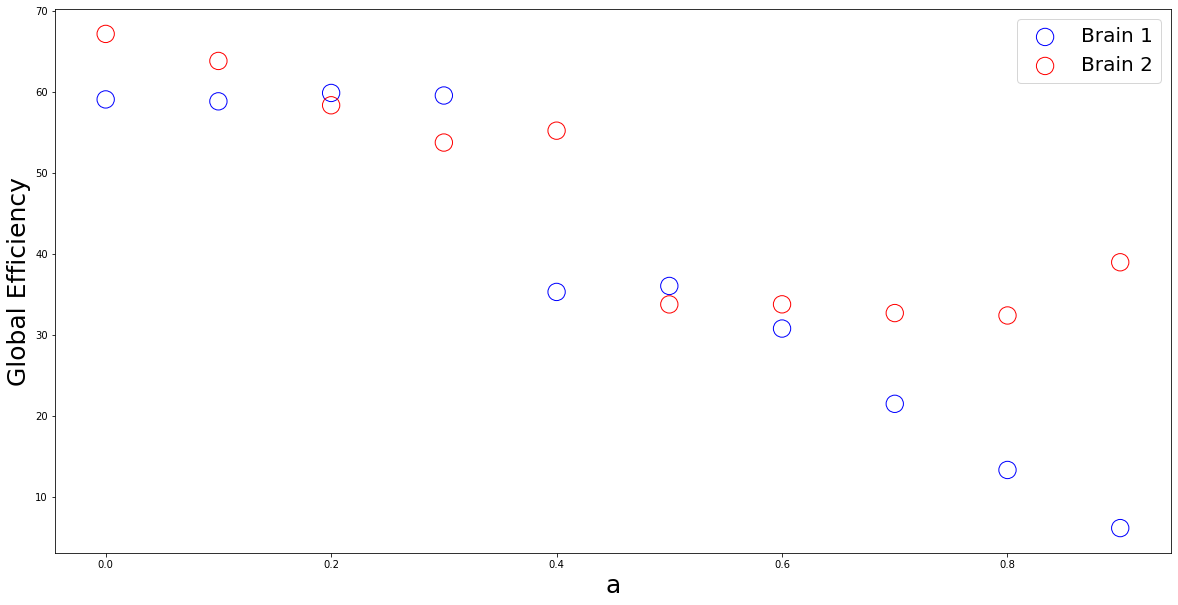

In [87]:
mat = scipy.io.loadmat('brainGraph1.mat')
#extract only matrix from mat file whose field name is A 
#get adjacency matrix of HW2 Brain Graph 1
adjacencyMatrix=mat['W']
num_rows, num_cols = adjacencyMatrix.shape
E_glob_BR1=[]
E_diff_BR1=[]
t_brain_1=[]
t = np.arange(0.1, 1.0, 0.1)
for i in t:
    targetted_num_nodes=round(num_rows*i)
    copied_array=adjacencyMatrix
    a=copied_array[:targetted_num_nodes, :targetted_num_nodes]
    #call function and output reqired array in HW
    E_glob_BR1.append(globalEfficiency(a))
    E_diff_BR1.append(diffusionEfficiency(a))
    #add threshold graph to array for later use
    t_brain_1.append(a)

t_brain_1.append(adjacencyMatrix)
E_glob_BR1.append(globalEfficiency(adjacencyMatrix))
E_diff_BR1.append(diffusionEfficiency(adjacencyMatrix))

#get adjacency matrix of HW2 Brain Graph 2
mat = scipy.io.loadmat('brainGraph2.mat')
#extract only matrix from mat file whose field name is A 
adjacencyMatrix=mat['W']
num_rows, num_cols = adjacencyMatrix.shape
E_glob_BR2=[]
E_diff_BR2=[]
t_brain_2=[]
for i in t:
    targetted_num_nodes=round(num_rows*i)
    copied_array=adjacencyMatrix
    a=copied_array[:targetted_num_nodes, :targetted_num_nodes]
    #call function and output reqired array in HW
    E_glob_BR2.append(globalEfficiency(a))
    E_diff_BR2.append(diffusionEfficiency(a))
    #add threshold graph to array for later use
    t_brain_2.append(a)
    
t_brain_2.append(adjacencyMatrix)
E_glob_BR2.append(globalEfficiency(adjacencyMatrix))
E_diff_BR2.append(diffusionEfficiency(adjacencyMatrix))

E_glob_BR1.reverse()
E_diff_BR1.reverse()
E_glob_BR2.reverse()
E_diff_BR2.reverse()
x = np.arange(0.0, 1.0, 0.1)
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(x, E_glob_BR1,marker='o',color='b',s=300,facecolors='none')
ax.scatter(x,E_glob_BR2, marker='o', color='r',s=300,facecolors='none')
ax.legend(labels=['Brain 1', 'Brain 2'],fontsize=20,loc='best')
ax.set_ylabel('Global Efficiency',fontsize=25)
ax.set_xlabel('a',fontsize=25)
plt.show()

# QUESTION (2.4) In a second figure, plot the diffusion efficiency E diff of both matrices against α. [5%]

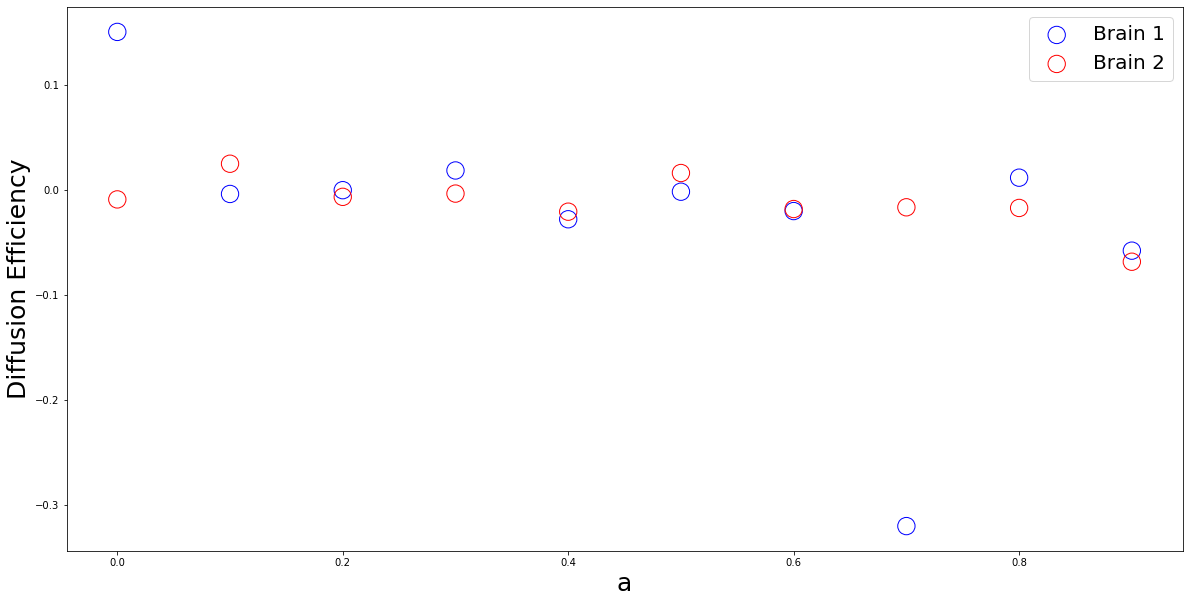

In [88]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(x, E_diff_BR1,marker='o',color='b',s=300,facecolors='none')
ax.scatter(x,E_diff_BR2, marker='o', color='r',s=300,facecolors='none')
ax.legend(labels=['Brain 1', 'Brain 2'],fontsize=20,loc='best')
ax.set_ylabel('Diffusion Efficiency',fontsize=25)
ax.set_xlabel('a',fontsize=25)
plt.show()

# QUESTION (2.5) What conclusions can you derive from previous plots? Compare diffusion and global efficiencies within a single graph and across both graphs. [5%]

Diffusion Efficiency of Brain 1 is higher without thresholding. When thresholding starts, Brain 1 shows significant decrease while Brain 2 doesn't. At threshold value 0.6 both Brains have the same efficiency value. But at threshold 0.7 Brain 1 drops its efficiency quickly while Brain 2 stays almost the same. According to graph Brain 2 has more stability than Brain 1 against any connection loss. Interestingly after losing its 0.8 of nodes Brain 1 increases diffusion efficiency as if its remaining nodes (central) has high degree centrality. At threshold 0.9 both brains have nearly the same efficiency. To conclude, Brain 2 doesn't show any abnormal drop or increase during thresholding but Brain 1 acts notably different. Brain 2 is better than Brain 1 against attacks.

Global Efficiency of Brain 2 is higher than Brain 1 without thresholding. While Brain 1 shows significant decrease after threshold 0.4 Brain 2 decreases significantly at threshold 0.5. Meaning that Brain 1 is more vulnerable than Brain 2. Brain 1's global efficiency decreases easier than Brain 2. At 0.2 and 0.5 global efficiency of Brain 1 is higher than Brain 2 but still Brain 1 decreases earlier than Brain 2 and keeps decreasing at each threshold value. On the contrary Brain 2 shows slow decrease at each threshold value compare to Brain 1. At 0.9 threshold Brain 2 show increase while Brain 1 almost loses its entire global efficiency.   

# QUESTION (2.6) Plot a morphospace b [1] for the set of thresholded brain graphs at α ∈ [0 : 0.1 : 0.9], where the x-axis denotes E dif f and y-axis denotes E glob. Use two different colors to compare the two thresholded graph sets derived from each brain graph, respectively. [10%]

In [89]:
#get graph sets of BRAIN 1 and BRAIN 2 for each threshold
B1=[]
B2=[]
for g in t_brain_1:
    B1.append(nx.from_numpy_matrix(g).copy())
for g in t_brain_2:
    B2.append(nx.from_numpy_matrix(g).copy())
sampled_networks=[B1,B2]

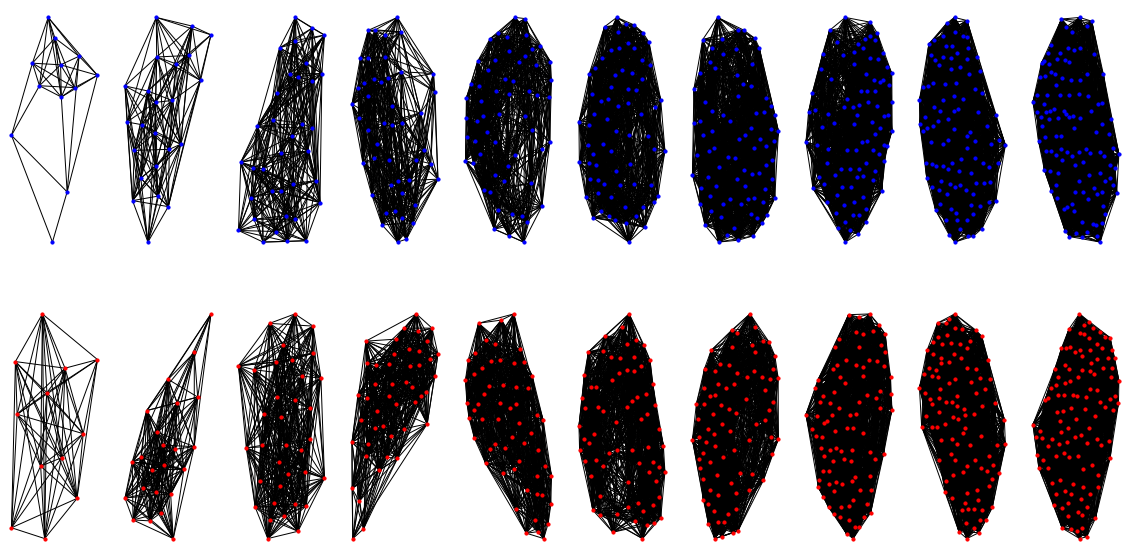

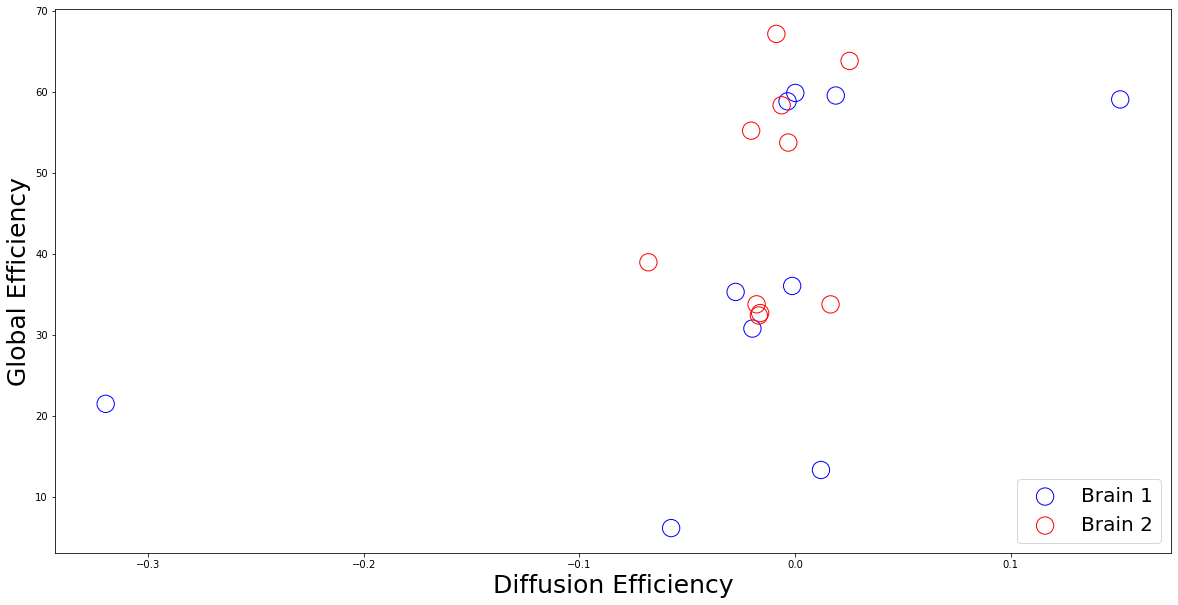

In [90]:
fig, axes = plt.subplots(nrows=2, ncols=10,figsize=(20, 10))
#ax = axes.flatten()
x=E_diff_BR1
y=E_glob_BR1

n_color='blue'
for i in range(2):
    for j in range(10):
        #G = nx.path_graph(sampled_networks[i][j])
        #pos = nx.spectral_layout(G)
        nx.draw(sampled_networks[i][j], ax=axes[i][j],node_color=n_color, node_size=10) # Drawing the graph, assign randomized colors
        #axes[i][j].set_axis_off()
    n_color='red'
plt.show()

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(E_diff_BR1,E_glob_BR1,marker='o',color='b',s=300,facecolors='none')
ax.scatter(E_diff_BR2,E_glob_BR2, marker='o', color='r',s=300,facecolors='none')
ax.legend(labels=['Brain 1', 'Brain 2'],fontsize=20,loc='lower right')
ax.set_ylabel('Global Efficiency',fontsize=25)
ax.set_xlabel('Diffusion Efficiency',fontsize=25)
plt.show()

# OUESTION (2.7) Discuss the information flow efficiency for both brain graphs based on your morphospace plot. [5%]

Brain 2 has better information flow efficiency than Brain 1. Only Brain 1 shows (L, L) in both efficiency measures. None of the brains show (L, H) (Global, Diffusion) value at any threshold. Brain 1 has the lowest information flow efficiency. Brain 2 captures the right upper part of the space (H, H) having the high efficiency values in both measures at most of the threshold values. Brain 1 has the lowest information flow efficiency at 0.9 threshold and captures right upper and lower parts of the plot at other thresholds (mostly right lower (L, L)). Brain 2 shows higher information flow efficiency at any threshold value.

# QUESTION (3.1) Write a function called selfDiffuse that takes (i) a weighted graph adjacency matrix (i.e., similarity matrix) W and outputs the diffused matrix W ? (check algorithm fig:3.). Make sure that your algorithm automatically sets the optimal number of diffusion iterations t ? as explained in the paper [2]. [10%]

In [84]:
def selfDiffuse(W):    
    #diff_matrix
    #create graph from adjacency matrix
    G = nx.from_numpy_matrix(W)
    #assign number of nodes to N
    N=G.number_of_nodes()
    #Initialize D matrix NxN 
    D= np.zeros((N, N), float)
    #create I matrix
    I= np.zeros((N, N), float)
    np.fill_diagonal(I, 1)
    #Initialize variables 
    ik_element=[]
    for i in range(N):
        ik_sum=0
        for k in range(N):
                ik_sum +=W[i][k]
                
        ik_element.append(ik_sum)
                
    an_array = np.array(ik_element)
    np.fill_diagonal(D, an_array)
    #calculate P=D**-1W
    P = np.linalg.inv(D) @ W
    #sigma_=0
    for n in range(100):
     #   for i in range(N):
      #      sigma_ += 1/Xij[n][i]
            
    #diff_eff = (1/(N*(N-1)))*sigma_
    #print("E_diff= {0}\t\t".format(diff_eff))
    #return diff_matrix
    
    

In [85]:
mat = scipy.io.loadmat('brainGraph1.mat')
#extract only matrix from mat file whose field name is A 
#get adjacency matrix of HW2 Brain Graph 1
adjacencyMatrix=mat['W']
selfDiffuse(adjacencyMatrix)

[[17.28755173  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         12.90463742  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         11.31395089 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 17.66329553  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         18.35765229
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  15.33755008]]
[[17.28755173  8.0460885   7.69109287 ...  0.          0.
   0.        ]
 [ 6.00616307 12.90463742  2.49112516 ...  0.          0.
   0.        ]
 [ 5.03348585  2.18405732 11.31395089 ...  0.29206813  0.
   0.        ]
 ...
 [ 0.          0.          0.45597562 ... 17.66329553 10.57874295
   8.06395206]
 [ 0.          0.          0.         ... 10.99460089 18.35765229
  12.81592473]
 [ 0.          0.          0.         ...  7.00216267 10.70751773
  15.33755008]]
[[0.05784509 0.02692265 0.02573482 ... 0.         0.         0.        ]
 [0.036

In [ ]:

mat = scipy.io.loadmat('brainGraph2.mat')
#extract only matrix from mat file whose field name is A 
#get adjacency matrix of HW2 Brain Graph 1
adjacencyMatrix=mat['W']
selfDiffuse(adjacencyMatrix)

# QUESTION (3.3) Given the 2 images taken from the Berkeley Segmentation Data Set c , generate the segmentation maps of each image using the Normalized Cut Python code https://github.com/marktao99/python/blob/master/CVP/samples/ncut.py. Display each original image and its corresponding output segmentation map. [10%]

In [92]:
from PIL import Image
from pylab import *
from numpy import *
from scipy.cluster.vq import *


def cluster(S,k,ndim):
    """ Spectral clustering from a similarity matrix."""
    
    # check for symmetry
    if sum(abs(S-S.T)) > 1e-10:
        print ('not symmetric')
    
    # create Laplacian matrix
    rowsum = sum(abs(S),axis=0)
    D = diag(1 / sqrt(rowsum + 1e-6))
    L = dot(D,dot(S,D))
    
    # compute eigenvectors of L
    U,sigma,V = linalg.svd(L,full_matrices=False)
    
    # create feature vector from ndim first eigenvectors
    # by stacking eigenvectors as columns
    features = array(V[:ndim]).T

    # k-means
    features = whiten(features)
    centroids,distortion = kmeans(features,k)
    code,distance = vq(features,centroids)
        
    return code,V


def ncut_graph_matrix(im,sigma_d=1e2,sigma_g=1e-2):
    """ Create matrix for normalized cut. The parameters are 
        the weights for pixel distance and pixel similarity. """
    
    m,n = im.shape[:2] 
    N = m*n
    
    # normalize and create feature vector of RGB or grayscale
    if len(im.shape)==3:
        for i in range(3):
            im[:,:,i] = im[:,:,i] / im[:,:,i].max()
        vim = im.reshape((-1,3))
    else:
        im = im / im.max()
        vim = im.flatten()
    
    # x,y coordinates for distance computation
    xx,yy = meshgrid(range(n),range(m))
    x,y = xx.flatten(),yy.flatten()
    
    # create matrix with edge weights
    W = zeros((N,N),'f')
    for i in range(N):
        for j in range(i,N):
            d = (x[i]-x[j])**2 + (y[i]-y[j])**2 
            W[i,j] = W[j,i] = exp(-1.0*sum((vim[i]-vim[j])**2)/sigma_g) * exp(-d/sigma_d)
    
    return W

MemoryError: Unable to allocate 88.8 GiB for an array with shape (154401, 154401) and data type float32

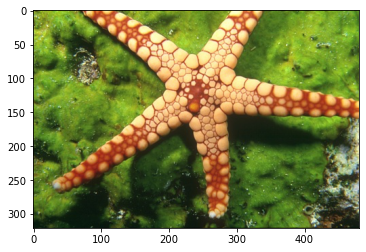

In [94]:
im=array(Image.open("image1.jpg"))
imshow(im)
W=ncut_graph_matrix(im)

In [ ]:
im=array(Image.open("image2.jpg"))
imshow(im)
W=ncut_graph_matrix(im)

In [ ]:
#for all fraction values
for f in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]: 
    print(f)
    #take a copy of random graph
    copy_ER_error=np.array(copy_ER)
    #call randomError function with inputs
    new_adj=randomError(copy_ER_error,f)
    #wait until it creates without interruption
    time.sleep(3)
    #cast returned graph(hw requires) to matrix
    new_adj_=nx.to_numpy_array(new_adj)
    #call LCC function and store returned values S, d and graph of LCC
    S,d,G_sub=largestConnectedComponent(new_adj_)
    time.sleep(3)
    #add d to its storage array for ER
    ER_diameter_random.append(d)
    #add S to its storage array for ER
    ER_S_random.append(S)
    
time.sleep(3)

In [ ]:
#function takes input adjacency matrix and fraction of nodes to remove
def randomError(adjMatrix,fraction):
    #in case input f has more than one decimals then round 
    f=round(fraction,1)
    #cast matrix to pandas DataFrame object
    df = pd.DataFrame(adjMatrix)
    #create empty DataFrame to store remaining nodes
    remaining_adj=pd.DataFrame()
    #pandas library has a method called 'sample' which samples out the sub frame by given fraction. That's why I sent (1-f). 
    #It selectes sampled rows randomly and with the same 'seed' it selects the same random columns to sample.
    #Both columns and rows of sent fraction is going to be removed to create square matrix so we sample twice for rows and columns
    remaining_adj=df.sample(frac=1-f, replace=False, random_state=500).sample(frac=1-f, replace=False, random_state=500,axis=1)
    #create graph from adjacency matrix
    G_after_error = nx.from_pandas_adjacency(remaining_adj, create_using=nx.Graph)
    #return adjacency matrix graph 
    return G_after_error

## Part A: Simulate exponential and free-scale networks

In [1384]:
#Implement Part A

In [1385]:
#Erdos-Renyi codes are from example file with required changes implemented
V = 200 # node count from hw
min_p = 0.08 # Specific minimum p value for Erdos-Renyi model
max_p = 0.85 # Specific maximum p value for Erdos-Renyi model

# Erdos-Renyi is a generative model. 
graph_count = 30 # to be used for erdös and scale-free graphs, seperately
node_draw_size = 75 # Node circle size in plots

seed = 1773 

## DO NOT CHANGE
np.random.seed(seed)
graph_creation_seed = np.random.randint(seed, size = graph_count*150000) ## for graph_count*150000 creations just in case of creating not connected graphs
graph_creation_seed = [int(i) for i in graph_creation_seed]
max_solver_iterations = 1000000000

In [1386]:
## Setting different Erdös-Renyi probabilities to prevent very similar node-degreed graphs
probs = np.linspace(min_p, max_p, num=graph_count)

# Creating a graph array to easily iterate over them
erdos_array = []

seed_i = 0
i = 0

print("Creating Erdös-Renyi graphs..")

#30 graphs are goint to be stored in arrays
while i < graph_count:
    #we start building graphs by library
    temp_graph = erdos_renyi_graph(V, probs[i], seed = graph_creation_seed[seed_i], directed = False)
    
    #add new generated graph to array if its fully connected
    if nx.is_connected(temp_graph): 
        erdos_array.append(temp_graph.copy())
    else:
        i -= 1 ## try creating again
        
    seed_i += 1 ## changing the seed to create different graph
    i += 1

# #adding positive weights
for G in erdos_array:
    for (u, v) in G.edges():
        G.edges[u,v]['weight'] = random.randint(1, 10)

Creating Erdös-Renyi graphs..


In [1387]:
"""""this is a function for undirected SF (geeksforgeeks)"""""
def barabasi_albert_graph(n, m, seed=None):
    """Returns a random graph according to the Barabási–Albert preferential
    Attachment model.
  
  
    Parameters
    ----------
    n : Number of nodes
    m : Number of edges 
    
    NetworkXError
        If ``m`` does not satisfy ``1 <= m < n``. """  
    #first we check if node count is bigger than edge count
    if m < 1 or  m >=n:
        raise nx.NetworkXError("Barabási–Albert network must have m >= 1"
                               " and m < n, m = %d, n = %d" % (m, n))
    if seed is not None:
        random.seed(seed)
  
    # Add m initial nodes this is like creating a skeleton
    G=empty_graph(m)
    G.name="barabasi_albert_graph(%s,%s)"%(n,m)
    # Target nodes for new edges
    targets=list(range(m)) #how many nodes to add
    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes=[]
    # Start adding the other n-m nodes. The first node is m.
    source=m
    #here we add edges
    while source<n:
        # Add edges to m nodes from the source.
        G.add_edges_from(zip(*m,targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend(*m)
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachement)
        targets = _random_subset(repeated_nodes,m)
        source += 1
    return G #returns graph

In [1388]:
# Creating Scale-free graphs
print("Creating Scale-free graphs..")
time.sleep(1)

i = 0
scale_free_array = []
#filling the array until counts to 30
while i < graph_count:
    #200 nodes as hw requires
    temp_graph= nx.barabasi_albert_graph(200,10,seed_i)
    scale_free_array.append(temp_graph.copy())        
    seed_i += 1 ## changing the seed to create different graph
    i += 1
#adding positive weights
for G in scale_free_array:
    for (u, v) in G.edges():
        G.edges[u,v]['weight'] = random.randint(1, 10)

Creating Scale-free graphs..


# QUESTION 5 Visualize two random graphs you simulated (ER and SF)

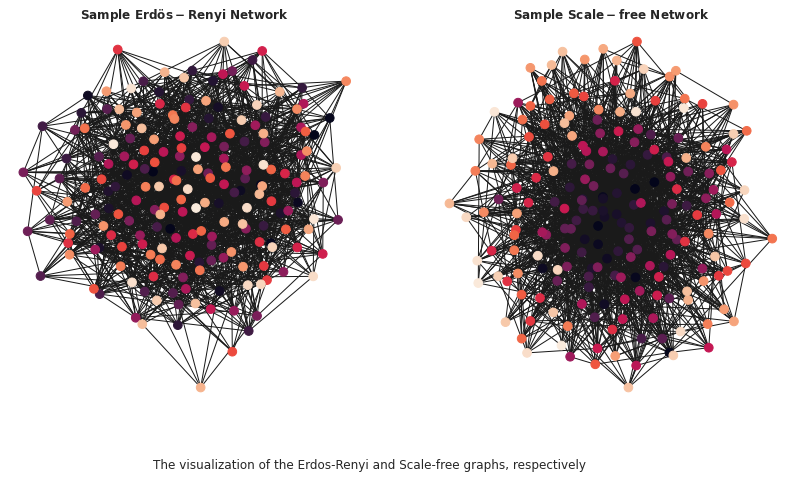

In [1389]:
sampled_networks = [erdos_array[0], scale_free_array[0]] # Selecting the first pair of Erdos and Scale-free versions

# Creating the plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = axes.flatten()
ax[1].title.set_text(r"$\mathbf{Sample\ Scale-free\ Network}$")
ax[0].title.set_text(r"$\mathbf{Sample\ Erdös-Renyi\ Network}$")

# Iterating in the pair
for i in range(2):
    nx.draw(sampled_networks[i], ax=ax[i], node_color=range(V), node_size=75) # Drawing the graph, assign randomized colors
    ax[i].set_axis_off()
    
# Plotting with the caption
fig.text(.27,0,"The visualization of the Erdos-Renyi and Scale-free graphs, respectively")
plt.show()

In [1390]:
## Defining a centrality list to use later
centralities = []

In [1391]:
#function to calculate degree centrality
def degree_centrality(G):
    return dict(G.degree(weight = "weight"))

centralities.append(degree_centrality)

In [1392]:
#function to calculate eigenvector centrality
def eigenvector_centrality(G):
    return nx.eigenvector_centrality(G, weight = "weight", max_iter = max_solver_iterations)

centralities.append(eigenvector_centrality)

In [1393]:
#creating empty array for 30 graphs to store centrality measures
erdos_centralities = np.zeros((graph_count, len(centralities), V))

#Erdos-Renyi both centralities are calculated and stored in array
for erdos_id, erdos in enumerate(tqdm(erdos_array)):
    for centrality_id, centrality in enumerate(centralities):
        erdos_centralities[erdos_id, centrality_id] = np.nan_to_num(np.array(list(centrality(erdos).values())), 0)

100%|██████████| 30/30 [00:02<00:00, 11.08it/s]


In [1394]:
#creating empty array for 30 graphs to store centrality measures
scalefree_centralities = np.zeros((graph_count, len(centralities), V))

#Scale-free both centralities are calculated and stored in array
for scalefree_id, scalefree in enumerate(tqdm(scale_free_array)):
    for centrality_id, centrality in enumerate(centralities):
        scalefree_centralities[scalefree_id, centrality_id] = np.nan_to_num(np.array(list(centrality(scalefree).values())), 0)

100%|██████████| 30/30 [00:01<00:00, 26.78it/s]


In [1395]:
#degree centralities are calculated for ER and SF graphs and summed as requested in Question 6
total_erdos_degree = [] 
for centrality_results in tqdm(erdos_centralities):  #tqdm for simulation
    total_erdos_degree.append(centrality_results[0,:].sum())

total_scalefree_degree = [] 
for centrality_results in tqdm(scalefree_centralities): 
    total_scalefree_degree.append(centrality_results[0,:].sum())
    


100%|██████████| 30/30 [00:00<00:00, 72274.05it/s]


In [1396]:
#eigenvector centralities are calculated for ER and SF graphs and summed as requested in Question 6

total_erdos_eigen = [] 
for centrality_results in tqdm(erdos_centralities): #tqdm for simulation
    total_erdos_eigen.append(centrality_results[1,:].sum())
    
total_scalefree_eigen = [] 
for centrality_results in tqdm(scalefree_centralities): 
    total_scalefree_eigen.append(centrality_results[1,:].sum())

100%|██████████| 30/30 [00:00<00:00, 64133.09it/s]


# QUESTION 6 Plot the overlaid distributions of the node strength centrality for all 30 ER graphs (transparent blue color) and the 30 SF graphs (transparent red color). What do you notice? Interpret your observation.

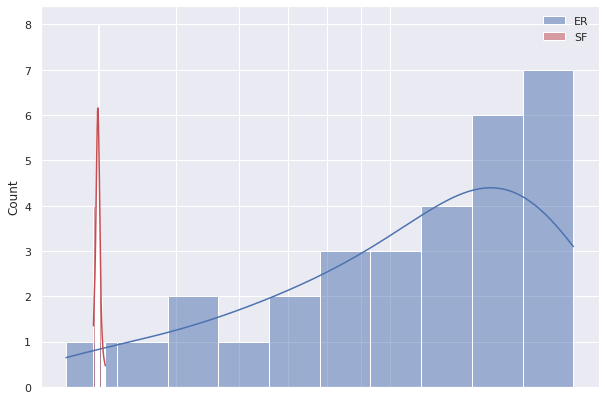

In [1397]:
#here I plot the total degree centralities in log scale overlaid for both ER and SF
arr_scale_degree=np.array(total_scalefree_degree)
arr_erdos_degree=np.array(total_erdos_degree)
#I used sns library for better visualization
sns.set(style="darkgrid")
fig, axs = plt.subplots(figsize=(10,7))
#I chose to set bin count 10 and kernel density estimation to show trend
sns.histplot(data=arr_erdos_degree, alpha=0.5, color='b',label="ER",kde=True,ax=axs,bins=10, log_scale=True)
sns.histplot(data=arr_scale_degree, alpha=0.5, color='r', label="SF",kde=True,ax=axs,bins=10, log_scale=True)
plt.legend(loc='best')
axs.set_xticks([30000,40000,50000,60000,70000, 80000])
plt.show()

# QUESTION 6 cont. 
ER degree centrality shows an exponential distribution, as expected. SF degree centraliy shows uniform distribution. Its values are around 20k but in ER its left skewed and values are more spread between 30k-80k

# QUESTION 7 Plot the overlaid distributions of the eigenvector centrality for all 30 ER graphs (transparent blue color) and the 30 SF graphs (transparent red color). What do you notice? Interpret your observation.

/home/gamze/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


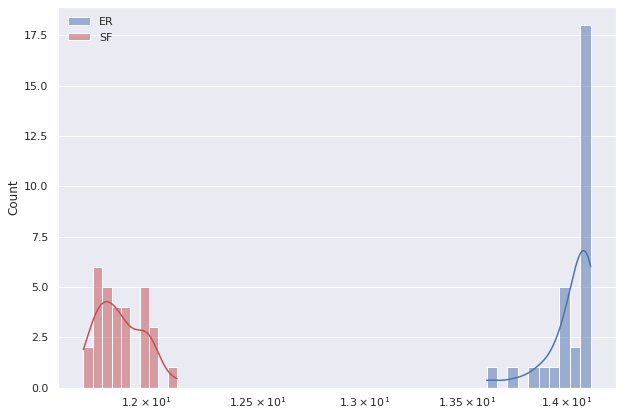

In [1398]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(figsize=(10,7))
sns.histplot(data=total_erdos_eigen, alpha=0.5, color='b',label="ER",kde=True,ax=axs,bins=10, log_scale=True)
sns.histplot(data=total_scalefree_eigen, alpha=0.5, color='r', label="SF",kde=True,ax=axs,bins=10, log_scale=True)
plt.legend(loc='best')
plt.show()

# QUESTION 7 cont.
Eİgen value distribution shows similar behavior. Again ER eigen values have exponential distribution while SF show Gaussian. Similarly ER values are left skewed.

## Part B: Analyzing Erdos-Renyi and Scale-Free graphs in both random error and target attack scenarios

In [1399]:
#Implement PART B:


/home/gamze/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# QUESTION 1 Code up a function called ‘findPercolationThreshold’, where you input a positive weighted adjacency matrix and it automatically outputs its percolation threshold fc. 

In [1400]:
#takes input adjacency matrix
def findPercolationThreshold(adjMatrix):
    """Return the threshold value for adjacency matrix"""
    first_node = 0 #marks first node 
    last_node = len(adjMatrix) - 1 #marks last node len-1 since index starts from 0
    #ravel flattens the array, meaning it return 1-D array. For this example I used 4x4 matrix and ravel returns 1x16
    #np.unique finds non-repeating elements in matrix and sorts and assigns array of unique elements to variable 'probabilities' 
    probabilities = np.unique(adjMatrix.ravel()) 
    low = 0 #lowest value
    high = len(probabilities) #highest value as count of unique elements
    
#if difference between lowest and highest numbers bigger than 1, loops
    while high - low > 1:
        # i is median values index
        i = (high + low) // 2
        #find new median value at each time it loops and assign it to 'prob'
        prob = probabilities[i]
        #take a copy of input adjacency matrix
        copied_array = np.array(adjMatrix)
        #give 0.0 to items smaller than calculated median value at each time. We need to keep values bigger than median
        copied_array[copied_array < prob] = 0.0
        #Call NX library and build graph from adjacency matrix 
        graph = nx.from_numpy_matrix(copied_array)
        #if there exists a path (edge) between first and last node then set low=i otherwise high=i
        #This means our median value is going to increase next loop because in if condition new lowest value becomes previous median value         
        if nx.has_path(graph, first_node, last_node):
            low = i
        else: # if there is no path then median value will decrease
            high = i
    
    return probabilities[low] #returns elements of latest median value index as threshold

# QUESTION 2 Comment out each line of your ‘findPercolationThreshold’ function and add a text box explaining how your algorithm works.
findPercolationThreshold function takes an input adjacency matrix and returns threshold element as index of latest estimated median value. It iterates over array of unique sorted elements until lowest and highest indexes meets in middle. At each time algorithm zeros out elements smaller than calculated median value. Then it builds graph to see paths between nodes, if there is a path, median value increases since new lowest value increases (low=i). Otherwise median value decreases since new highest value becomes previous (smaller since its sorted) median value. At the end of iteration returned value is index of median pointing threshold element in unique array.

In [1401]:
adjMx=np.array([[0,      0.3,    0.4,    0.1],
                        [0.3,    0,      0.9,    0.2],
                        [0.4,    0.9,    0,      0.7],
                        [0.1,    0.2,    0.7,   0]])

In [1402]:
print('Threshold is {}'.format(findPercolationThreshold(adjMx)))

Threshold is 0.4


In [1403]:
adjMx_2=np.array([[0,    0,    0,    0, 0, 1,0,0],#0
                  [0,    0,    0,    0, 1, 0,0,1],#1
                  [0,    0,    1,    1, 1, 0,0,1],#2
                  [0,    1,    0,    1, 0, 0,0,0],#3
                  [0,    0,    1,    0, 1, 0,0,1],#4 
                  [1,    0,    0,    0, 0, 1,1,0],#5
                  [0,    0,    0,    0, 0, 1,0,0],#6
                  [0,    0,    0,    0, 0, 0,0,0]])#7

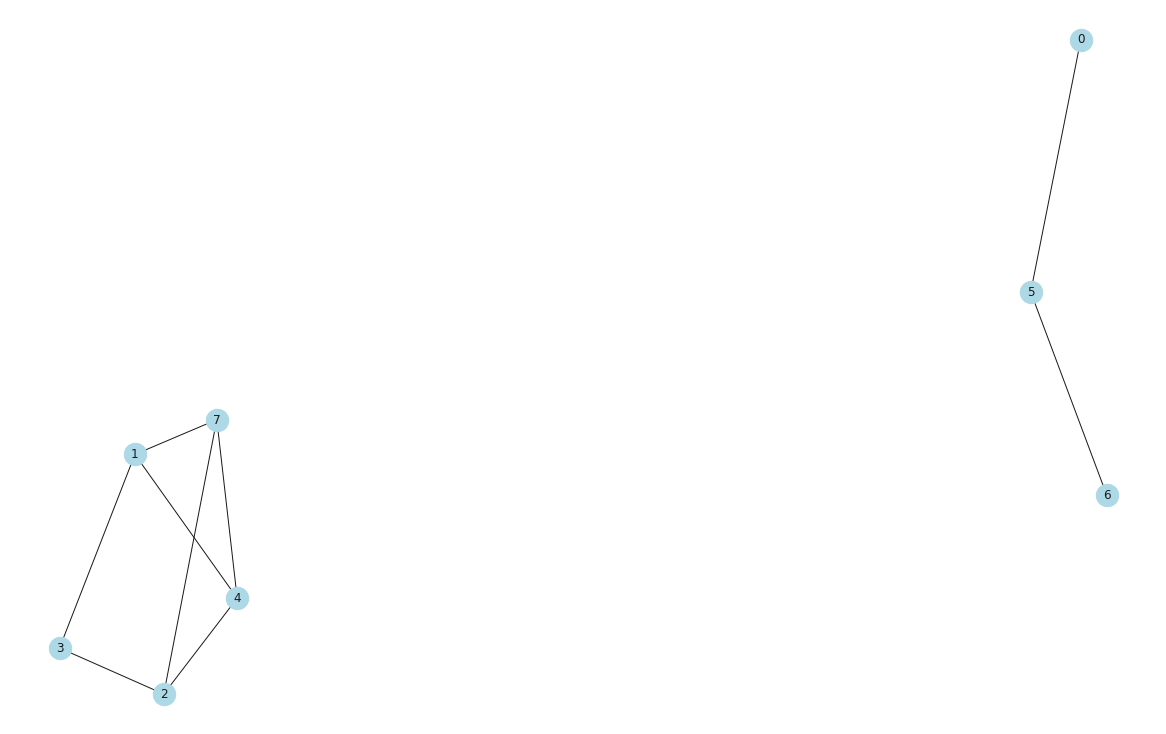

In [1404]:
G = nx.from_numpy_matrix(adjMx_2)
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500)

# QUESTION 3 Code up a function called ‘largestConnectedComponent’, where you input a positive weighted adjacency matrix and it automatically outputs (1) the largest connected component graph, (2) its node size S and (3) its diameter d defined as the average of the shortest paths between all pairs of nodes in the large connected component graph.

In [1405]:
#takes input adjacency matrix
def largestConnectedComponent(adjMatrix):
    #store a array copy of input matrix
    copied_array = adjMatrix
    #build graph from NX library
    graph = nx.from_numpy_matrix(copied_array)
    #assign max of connected components
    largest = max(nx.connected_components(graph), key=len)
    #create graph of largest connected component
    G_sub = graph.subgraph(largest)
    #print length of LCC
    print("S: ",len(largest))
    #print diameter d of LCC 
    print("d: ",nx.average_shortest_path_length(G_sub))
    return len(largest),nx.average_shortest_path_length(G_sub),G_sub #return length, diameter and graph of LCC

# QUESTION 4 Comment out each line of your ‘largestConnectedComponent’ function and add a text box explaining how your algorithm works.
function takes input adjacency matrix and returns LCC length, diameter and graph. NX library takes input graph and returns all connected components. Since HW asks for largest one it takes max. Later to calculate average of all shortest paths of LCC it again creates LCC sub graph. 

S:  5
d:  1.3


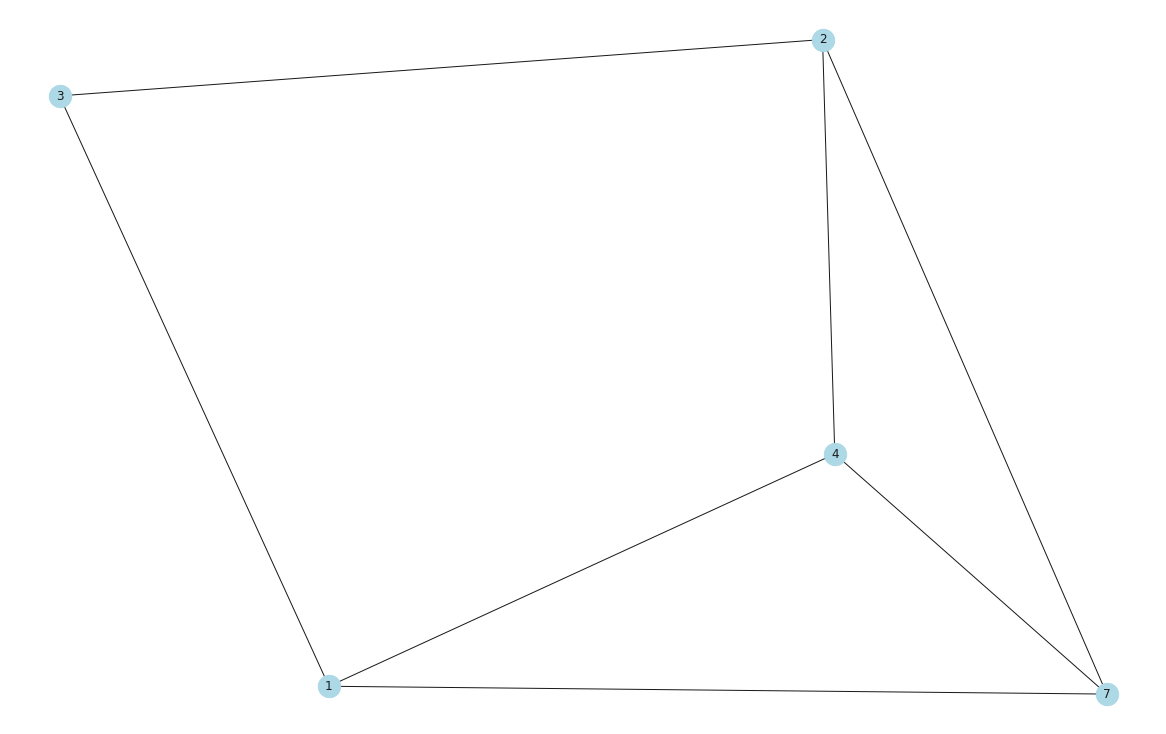

In [1406]:
l,p,G_sub=largestConnectedComponent(adjMx_2)
nx.draw(G_sub, with_labels=True, node_color='lightblue', node_size=500)

# QUESTION 5 Random failure scenario. Code up a function called ‘randomError’, inputting (1) the graph adjacency matrix and (2) the fraction (between 0 and 1) of nodes to be randomly removed and returns the adjancy matrix graph excluding the removed nodes. Comment out the code and explain in a text box how it works.

In [1407]:
#function takes input adjacency matrix and fraction of nodes to remove
def randomError(adjMatrix,fraction):
    #in case input f has more than one decimals then round 
    f=round(fraction,1)
    #cast matrix to pandas DataFrame object
    df = pd.DataFrame(adjMatrix)
    #create empty DataFrame to store remaining nodes
    remaining_adj=pd.DataFrame()
    #pandas library has a method called 'sample' which samples out the sub frame by given fraction. That's why I sent (1-f). 
    #It selectes sampled rows randomly and with the same 'seed' it selects the same random columns to sample.
    #Both columns and rows of sent fraction is going to be removed to create square matrix so we sample twice for rows and columns
    remaining_adj=df.sample(frac=1-f, replace=False, random_state=500).sample(frac=1-f, replace=False, random_state=500,axis=1)
    #create graph from adjacency matrix
    G_after_error = nx.from_pandas_adjacency(remaining_adj, create_using=nx.Graph)
    #return adjacency matrix graph 
    return G_after_error

# QUESTION 5 cont.
Function takes input adjacency matrix and fraction of nodes to remove. Sample method extracts rows and columns of given 1-fraction. Because this method doesn't work by removing the nodes rather extract them as sub array.

In [1408]:
adjMx_3=np.array([[0,      0.3,    0.4,    0.7,      0.7,    0.2,    0.1,    0.9,    0,      0.1],
                  [0.3,    0,      0.9,    0.2,      0.3,    0.4,    0.7,    0.3,    0.4,    0.7],
                  [0.3,    0,      0.9,    0.2,      0.3,    0.4,    0.7,    0.3,    0.4,    0.7],         
                  [0.4,    0.9,    0,      0.1,      0,      0.9,    0.2,    0,      0.9,    0.2],          
                  [0.3,    0,      0.9,    0.2,      0.3,    0.4,    0.7,    0,      0.9,    0.2],
                  [0,      0.3,    0.4,    0.7,      0.9,    0,      0.1,    0.4,    0.9,    0],
                  [0.3,    0,      0.9,    0.2,      0.3,    0.4,    0.7,    0.9,    0,      0.1],
                  [0.4,    0.9,    0,      0.1,      0,      0.9,    0.2,    0.9,    0,      0.1],
                  [0.4,    0.9,    0,      0.1,      0,      0.9,    0.2,    0,      0.9,    0.2],
                  [0.7,    0.2,    0.1,    0,        0.9,    0,      0.1,    0.3,    0,      0.9]])

Calculating remaining G...


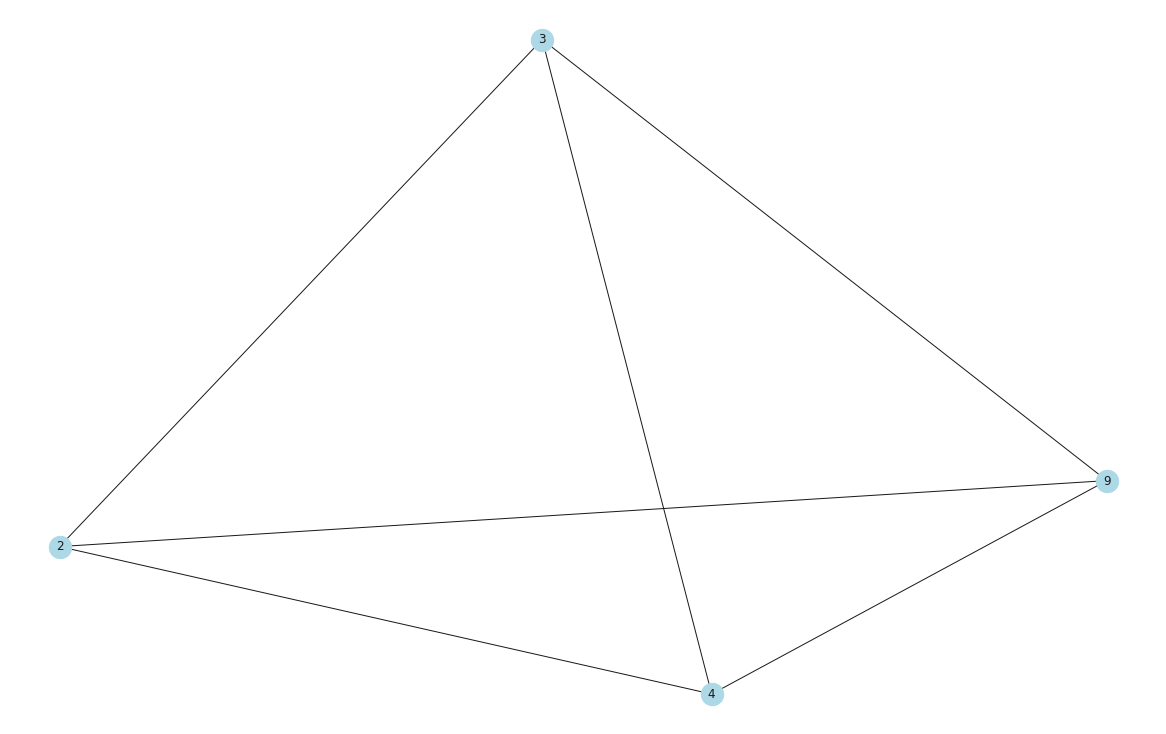

In [1409]:
print("Calculating remaining G...")
G_after_error=randomError(adjMx_3,0.6)
nx.draw(G_after_error,with_labels=True, node_color='lightblue', node_size=500)
time.sleep(3)

# QUESTION 6 Target attack scenario. Code up a function called ‘targetAttack’, inputting (1) the graph adjacency matrix and (2) the fraction (between 0 and 1) of nodes to be attacked removed and returns the adjancy matrix graph excluding the removed nodes. Note that the nodes to be removed are those with the highest strength. Comment out the code and explain in a text box how it works.

In [1410]:
#function takes input adjacency matrix and fraction of nodes to remove
def targetAttack(adjMatrix,fraction):
    #store number of rows and columns of input matrix 
    num_rows, num_cols = adjMatrix.shape
    #store copy of matrix
    copied_array=adjMatrix
    #in case input f has more than one decimals round 
    f=round(fraction,1)
    #fraction of nodes to target to remove is assigned to a new variable
    targetted_num_nodes=round(num_rows*f)
    #use copied array to create graph object
    G = nx.from_numpy_matrix(copied_array)
    #store degree centrality values in a dictionary {node: strength} 
    dict_strength=degree_centrality(G)
    #sort node strengths from highest to lowest by setting reverse=True.  
    dict_sorted_strength = {k: v for k, v in sorted(dict_strength.items(),reverse=True ,key=lambda item: item[1])}
    #Targetted node-strength pairs stored in targetted_nodes list
    targetted_nodes= list(dict_sorted_strength.items())[:targetted_num_nodes]
    #cast list to pandas DataFrame object to better work with to extract node numbers.
    targetted_nodes_indexes = pd.DataFrame(targetted_nodes)
    #takes 0 index values of DataFrame object since its header is like [node_index; strength_value]
    targetted_nodes_indexes_=targetted_nodes_indexes[0]
    #remove targetted nodes of numpy array stored in the beginning and second input tells which nodes to remove, third input tells which axis
    remained_adj=np.delete(copied_array,targetted_nodes_indexes_,0)
    #repeat above process for columns as well to create a square matrix
    remained_adj_=np.delete(remained_adj,targetted_nodes_indexes_,1)
    #create graph from adjacency matrix
    G_after_attack = nx.from_numpy_matrix(remained_adj_, create_using=nx.Graph)
    #return adjacency matrix graph 
    return G_after_attack

# QUESTION 6 cont.
Function takes input adjacency matrix and fraction of nodes to remove. Delete method removes rows and columns of given fraction f. First we create a graph of input matrix and find its degree centralities of each node. After that, it sorts the nodes according to their strength from highest to lowest because HW requires us to target the strongest nodes. Working with sorted array makes it much easier. Then it returns resulted graph object

Calculating remaining G...


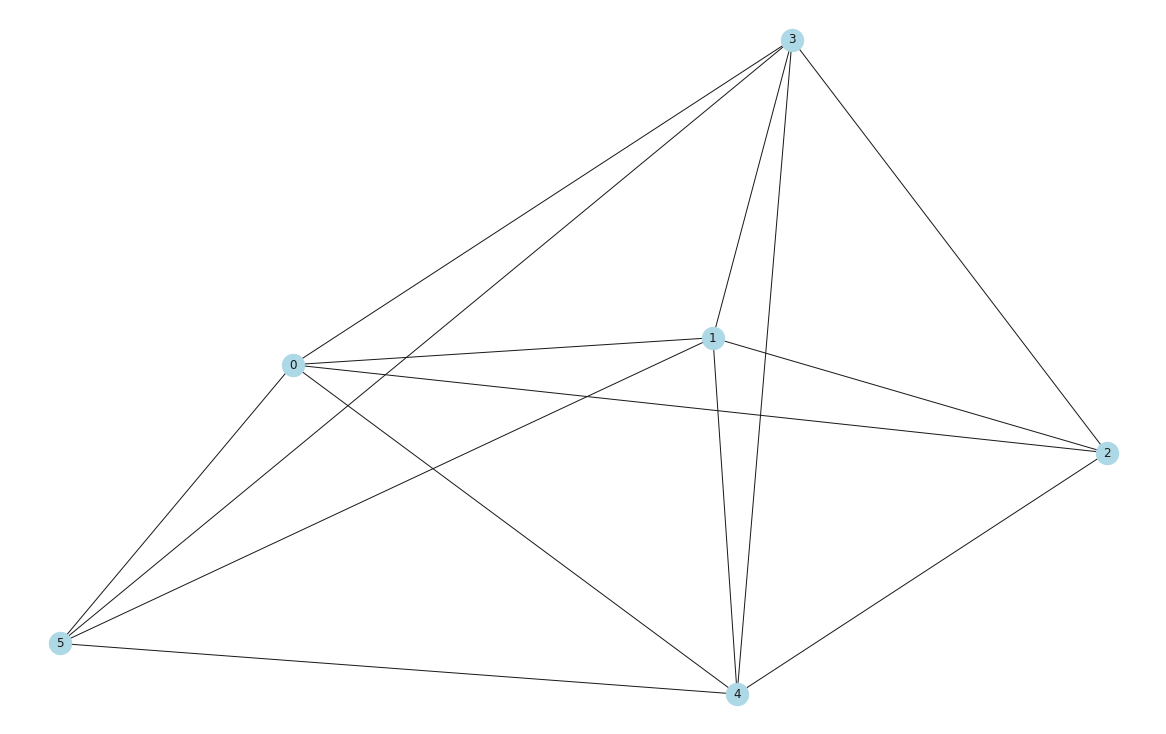

In [1411]:
print("Calculating remaining G...")
G_after_attack=targetAttack(adjMx_3,0.4)
nx.draw(G_after_attack,with_labels=True, node_color='lightblue', node_size=500)
time.sleep(3)

# QUESTION 7 Given one random ER network and one random SF network (you select two from your 60 simulated graphs), plot the diameter d of the largest connected component as in Fig. 2 against the fraction of removed nodes in both random error and target attack scenarios. The nodes need to be removed progressively (e.g., remove 0.1, 0.2, until reaching 0.8). 

In [1412]:
#these variables are going to be used for last question calculation of threshold of all graphs
t_ER=[]
t_SF=[]

In [1413]:
#Create adjacency matrixes randomly from graphs for ER and display its S and d 
ER_adj=nx.to_numpy_array(erdos_array[np.random.randint(1,30)])
copy_ER=np.array(ER_adj)
#add this graph to main storage array to use last question below
t_ER.append(findPercolationThreshold(copy_ER))
#initialize ER for t and S for randomError function return
ER_diameter_random=[]
ER_S_random=[]

#for all fraction values
for f in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]: 
    print(f)
    #take a copy of random graph
    copy_ER_error=np.array(copy_ER)
    #call randomError function with inputs
    new_adj=randomError(copy_ER_error,f)
    #wait until it creates without interruption
    time.sleep(3)
    #cast returned graph(hw requires) to matrix
    new_adj_=nx.to_numpy_array(new_adj)
    #call LCC function and store returned values S, d and graph of LCC
    S,d,G_sub=largestConnectedComponent(new_adj_)
    time.sleep(3)
    #add d to its storage array for ER
    ER_diameter_random.append(d)
    #add S to its storage array for ER
    ER_S_random.append(S)
    
time.sleep(3)

#initialize d and S values for targetAttack function return
ER_diameter_target=[]
ER_S_target=[]

for f in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]: 
    print(f)
    #take a copy of random graph
    copy_ER_target=np.array(copy_ER)
    #call targetAttack function with inputs
    new_adj=targetAttack(copy_ER_target,f)
    time.sleep(3)
    #cast returned graph(hw requires) to matrix
    new_adj_=nx.to_numpy_array(new_adj)
    #call LCC function and store returned values S, d and graph of LCC
    S,d,G_sub=largestConnectedComponent(new_adj_)
    time.sleep(3)
    #add d to its storage array for ER
    ER_diameter_target.append(d)
    #add S to its storage array for ER
    ER_S_target.append(S)
    
time.sleep(3)

0.1
S:  180
d:  1.6535692116697702
0.2
S:  160
d:  1.6516509433962263
0.3
S:  140
d:  1.6506680369989724
0.4
S:  120
d:  1.65
0.5
S:  100
d:  1.646060606060606
0.6
S:  80
d:  1.6414556962025317
0.7
S:  60
d:  1.6502824858757061
0.8
S:  40
d:  1.646153846153846
0.1
S:  180
d:  1.663376784605835
0.2
S:  160
d:  1.672877358490566
0.3
S:  140
d:  1.6809866392600206
0.4
S:  120
d:  1.6876750700280112
0.5
S:  100
d:  1.6961616161616162
0.6
S:  80
d:  1.7015822784810126
0.7
S:  60
d:  1.7112994350282487
0.8
S:  40
d:  1.7987179487179488


In [1414]:
#Create adjacency matrixes randomly from graphs for SF and display its S and d 
SF_adj=nx.to_numpy_array(scale_free_array[np.random.randint(1,30)])
copy_SF=np.array(SF_adj)
#add this graph to main storage array to use last question below
t_SF.append(findPercolationThreshold(copy_SF))
#initialize SF for t and S for randomError function return
SF_diameter_random=[]
SF_S_random=[]

#for all fraction values
for f in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]: 
    print(f)
    #take a copy of random graph
    copy_SF_error=np.array(copy_SF)
    #call randomError function with inputs
    new_adj=randomError(copy_SF_error,f)
    time.sleep(3)
    #cast returned graph(hw requires) to matrix
    new_adj_=nx.to_numpy_array(new_adj)
    #call LCC function and store returned values S, d and graph of LCC
    S,d,G_sub=largestConnectedComponent(new_adj_)
    time.sleep(3)
    #add d to its storage array for SF
    SF_diameter_random.append(d)
    #add s to its storage array for SF
    SF_S_random.append(S)
    
time.sleep(3)

#initialize d and S values for targetAttack function return
SF_diameter_target=[]
SF_S_target=[]

#for all fraction values
for f in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]: 
    print(f)
    #take a copy of random graph
    copy_SF_target=np.array(copy_SF)
    #call targetAttack function with inputs
    new_adj=targetAttack(copy_SF_target,f)
    time.sleep(3)
    #cast returned graph(hw requires) to matrix
    new_adj_=nx.to_numpy_array(new_adj)
    #call LCC function and store returned values S, d and graph of LCC
    S,d,G_sub=largestConnectedComponent(new_adj_)
    time.sleep(3)
    #add d to its storage array for SF
    SF_diameter_target.append(d)
    #add S to its storage array for SF
    SF_S_target.append(S)
    
time.sleep(3)

0.1
S:  180
d:  2.0772811918063314
0.2
S:  160
d:  2.1140723270440254
0.3
S:  140
d:  2.151284686536485
0.4
S:  120
d:  2.211624649859944
0.5
S:  100
d:  2.353939393939394
0.6
S:  80
d:  2.3800632911392405
0.7
S:  58
d:  2.5789473684210527
0.8
S:  34
d:  2.6506238859180034
0.1
S:  180
d:  2.3772191185599008
0.2
S:  160
d:  2.6360849056603772
0.3
S:  140
d:  2.94398766700925
0.4
S:  118
d:  3.403737505432421
0.5
S:  96
d:  4.169298245614035
0.6
S:  68
d:  4.790166812993855
0.7
S:  35
d:  6.0
0.8
S:  6
d:  2.1333333333333333


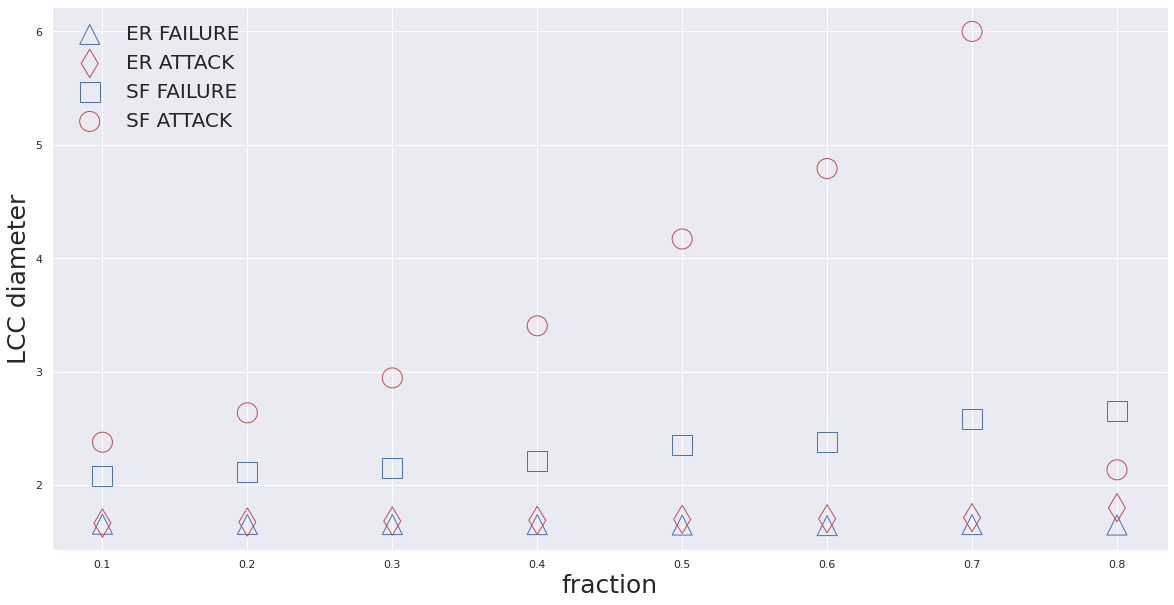

In [1415]:
#DIAMETER d PLOTS
x = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
y_ER_error = np.asarray(ER_diameter_random)
y_ER_attack=np.asarray(ER_diameter_target)
y_SF_error=np.asarray(SF_diameter_random)
y_SF_attack= np.asarray(SF_diameter_target)
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(x, y_ER_error,marker='^',color='b',s=400,facecolors='none')
ax.scatter(x,y_ER_attack, marker='d', color='r',s=400,facecolors='none')
ax.scatter(x,y_SF_error, marker='s', color='b',s=400,facecolors='none')
ax.scatter(x,y_SF_attack, marker='o', color='r',s=400,facecolors='none')
ax.legend(labels=['ER FAILURE', 'ER ATTACK', 'SF FAILURE','SF ATTACK'],fontsize=20,loc='upper left')
ax.set_ylabel('LCC diameter',fontsize=25)
ax.set_xlabel('fraction',fontsize=25)
plt.show()

# QUESTION 8 What conclusions can you derive about SF and ER networks and their resilience to random errors and target attacks? Are these conclusions in line with the paper paper[1]?

SF is vulnarable to target attack but sturdy when it comes to random errors. ER is stable against both random error and target attack strategies. This is concordant with the article

# QUESTION 9 Given one random ER network and one random SF network (you select two from your 60 simulated graphs), plot the size S of the LCC of the largest connected component as in Fig. 3 against the fraction of removed nodes in both random error and target attack scenarios. 

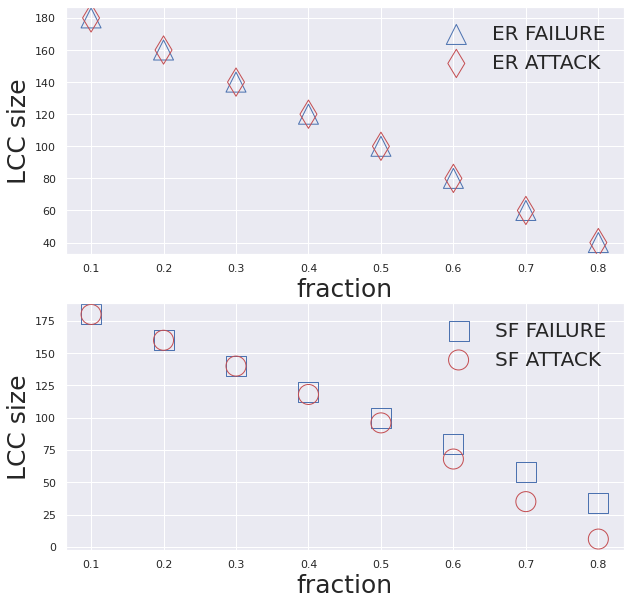

In [1416]:
#SIZE S PLOTS
x = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
y_ER_error = np.asarray(ER_S_random)
y_ER_attack=np.asarray(ER_S_target)
y_SF_error=np.asarray(SF_S_random)
y_SF_attack= np.asarray(SF_S_target)
fig, ax = plt.subplots(2,figsize=(10, 10))
ax[0].scatter(x, y_ER_error,marker='^',color='b',s=400,facecolors='none')
ax[0].scatter(x,y_ER_attack, marker='d', color='r',s=400,facecolors='none')
ax[1].scatter(x,y_SF_error, marker='s', color='b',s=400,facecolors='none')
ax[1].scatter(x,y_SF_attack, marker='o', color='r',s=400,facecolors='none')
ax[0].legend(labels=['ER FAILURE', 'ER ATTACK'],fontsize=20,loc='upper right')
ax[0].set_ylabel('LCC size',fontsize=25)
ax[0].set_xlabel('fraction',fontsize=25)
ax[1].set_ylabel('LCC size',fontsize=25)
ax[1].set_xlabel('fraction',fontsize=25)
ax[1].legend(labels=['SF FAILURE','SF ATTACK'],fontsize=20,loc='upper right')
plt.show()



# QUESTION 10 What conclusions can you derive about SF and ER networks and their resilience to random errors and target attacks? Are these conclusions in line with the paper paper[1]?

ER and SF shows similar behaviour under error and attack scenario. SF is more durable when high fragmentation. Again as article stated their response to errors and attacks is identical. Results are concordant.

# QUESTION 7-9 cont. Produce 3 more similar plots for 6 randomly selected ER and SF graphs (3 ER and 3 SF). Totally, you will have 4 plots for pairs of ER and SF networks to compare.
Same question so after collecting all randomly created graphs, I plotted them here for d and S sequentially. You have to wait a little for 6 figures to load.

S:  180
d:  2.08739913097455
S:  160
d:  2.127122641509434
S:  140
d:  2.1649537512846866
S:  120
d:  2.2250700280112046
S:  100
d:  2.2822222222222224
S:  80
d:  2.2905063291139243
S:  59
d:  2.40385739333723
S:  38
d:  2.725462304409673
S:  180
d:  2.3948479205462445
S:  160
d:  2.672641509433962
S:  140
d:  3.0617677286742033
S:  119
d:  3.5677253952428427
S:  92
d:  4.069995222169135
S:  63
d:  6.081413210445469
S:  34
d:  6.206773618538325
S:  3
d:  1.3333333333333333
S:  180
d:  1.523774053382992
S:  160
d:  1.5254716981132075
S:  140
d:  1.5281603288797534
S:  120
d:  1.52296918767507
S:  100
d:  1.5258585858585858
S:  80
d:  1.5205696202531647
S:  60
d:  1.5214689265536723
S:  40
d:  1.5128205128205128
S:  180
d:  1.5364990689013036
S:  160
d:  1.5458333333333334
S:  140
d:  1.5591983556012332
S:  120
d:  1.5680672268907563
S:  100
d:  1.578989898989899
S:  80
d:  1.5911392405063292
S:  60
d:  1.6050847457627118
S:  40
d:  1.6282051282051282


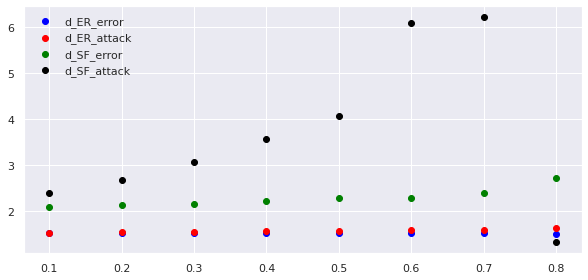

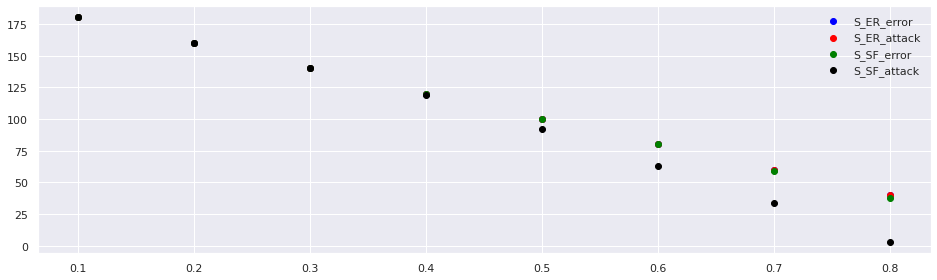

S:  180
d:  2.0817504655493484
S:  160
d:  2.107075471698113
S:  140
d:  2.157245632065776
S:  120
d:  2.2182072829131654
S:  100
d:  2.3082828282828283
S:  80
d:  2.289240506329114
S:  60
d:  2.614689265536723
S:  35
d:  2.7361344537815127
S:  180
d:  2.3623215394165116
S:  160
d:  2.629795597484277
S:  140
d:  3.0366906474820143
S:  120
d:  3.5105042016806722
S:  95
d:  4.118029115341545
S:  67
d:  5.241067390321121
S:  15
d:  3.3523809523809525
S:  6
d:  2.3333333333333335
S:  180
d:  1.8998758535071385
S:  160
d:  1.9160377358490566
S:  140
d:  1.9334018499486125
S:  120
d:  1.9703081232492998
S:  100
d:  2.0268686868686867
S:  80
d:  2.1199367088607595
S:  60
d:  2.210734463276836
S:  40
d:  2.551282051282051
S:  180
d:  1.9162631905648666
S:  160
d:  1.9502358490566039
S:  140
d:  1.9958890030832477
S:  120
d:  2.0551820728291315
S:  100
d:  2.1555555555555554
S:  80
d:  2.2734177215189875
S:  60
d:  2.461016949152542
S:  40
d:  2.6769230769230767


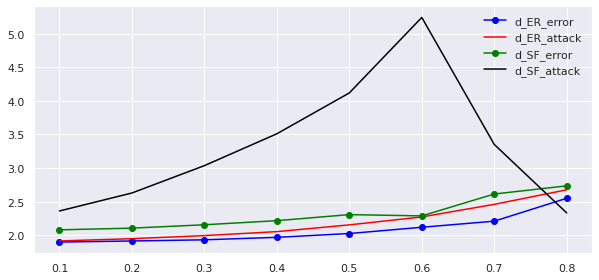

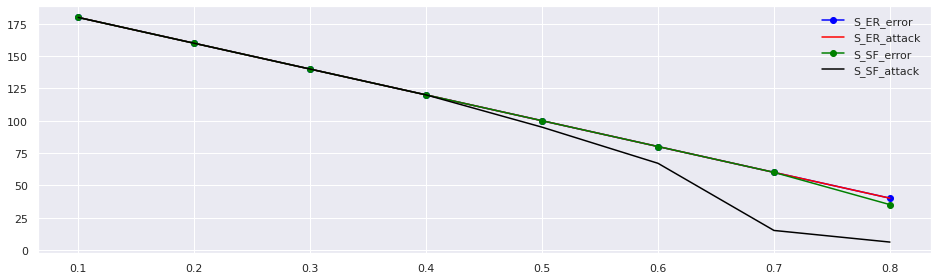

S:  180
d:  2.0781502172563626
S:  160
d:  2.101493710691824
S:  140
d:  2.150770811921891
S:  120
d:  2.234593837535014
S:  100
d:  2.3082828282828283
S:  80
d:  2.3063291139240505
S:  60
d:  2.4983050847457626
S:  35
d:  2.430252100840336
S:  180
d:  2.356983240223464
S:  160
d:  2.6442610062893084
S:  140
d:  2.9188078108941418
S:  119
d:  3.389830508474576
S:  94
d:  3.9430336307481126
S:  67
d:  4.606060606060606
S:  18
d:  4.594771241830065
S:  6
d:  2.3333333333333335
S:  180
d:  1.3837988826815641
S:  160
d:  1.3819182389937108
S:  140
d:  1.379650565262076
S:  120
d:  1.3831932773109243
S:  100
d:  1.38
S:  80
d:  1.3746835443037975
S:  60
d:  1.3632768361581922
S:  40
d:  1.3743589743589744
S:  180
d:  1.396772191185599
S:  160
d:  1.4060534591194969
S:  140
d:  1.416032887975334
S:  120
d:  1.4253501400560225
S:  100
d:  1.4321212121212121
S:  80
d:  1.4468354430379746
S:  60
d:  1.4542372881355932
S:  40
d:  1.471794871794872


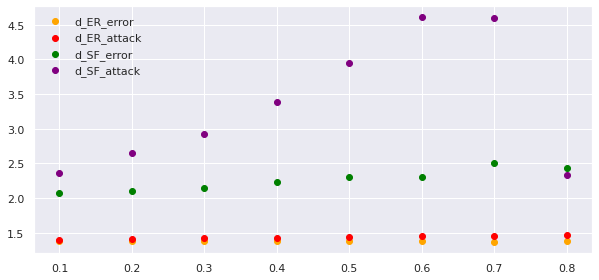

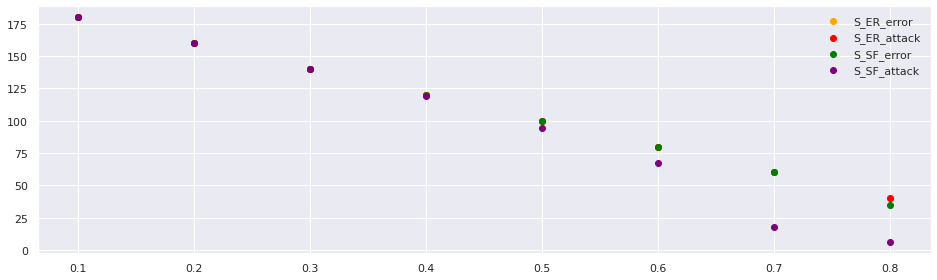

In [1417]:
#Here I repeat the same operations above for 6 more randomly selected ER and SF graphs.
#I add resulted graphs to storage arrays t_ER and t_SF since I need to calculate percolation thresholds for the last question.
#After calling randomError and targetAttack functions, I append returned d and S values as well to repeat similar plots as question requires

#this array is to plot x axis representing fraction 
x = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
#this for loop is to select total 6 more graphs from ER and SF cluester created at he beginning of homework
#copy_ER and copy_SF variables keeps randomly selected graphs
for i in range(3):
        
    SF_adj=nx.to_numpy_array(scale_free_array[np.random.randint(1,30)])
    copy_SF=np.array(SF_adj)

    ER_adj=nx.to_numpy_array(erdos_array[np.random.randint(1,30)])
    copy_ER=np.array(ER_adj)
    
    t_ER.append(findPercolationThreshold(copy_ER))
    t_SF.append(findPercolationThreshold(copy_SF))

    #keep d and S values for SF after random error
    SF_diameter_random=[]
    SF_S_random=[]

    for f in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]: 
        copy_SF_error=np.array(copy_SF)
        new_adj=randomError(copy_SF_error,f)
        time.sleep(3)
        new_adj_=nx.to_numpy_array(new_adj)
        S,d,G_sub=largestConnectedComponent(new_adj_)
        time.sleep(3)
        SF_diameter_random.append(d)
        SF_S_random.append(S)

    time.sleep(3)
    #keep d and S values for SF after target attack
    SF_diameter_target=[]
    SF_S_target=[]

    for f in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]: 
        copy_SF_target=np.array(copy_SF)
        new_adj=targetAttack(copy_SF_target,f)
        time.sleep(3)
        new_adj_=nx.to_numpy_array(new_adj)
        S,d,G_sub=largestConnectedComponent(new_adj_)
        time.sleep(3)
        SF_diameter_target.append(d)
        SF_S_target.append(S)

    time.sleep(3)
    #keep d and S values for ER after random error
    ER_diameter_random=[]
    ER_S_random=[]

    for f in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]: 
        copy_ER_error=np.array(copy_ER)
        new_adj=randomError(copy_ER_error,f)
        time.sleep(3)
        new_adj_=nx.to_numpy_array(new_adj)
        S,d,G_sub=largestConnectedComponent(new_adj_)
        time.sleep(3)
        ER_diameter_random.append(d)
        ER_S_random.append(S)

    time.sleep(3)
    #keep d and S values for ER after target attack
    ER_diameter_target=[]
    ER_S_target=[]

    for f in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]: 
        copy_ER_target=np.array(copy_ER)
        new_adj=targetAttack(copy_ER_target,f)
        time.sleep(3)
        new_adj_=nx.to_numpy_array(new_adj)
        S,d,G_sub=largestConnectedComponent(new_adj_)
        time.sleep(3)
        ER_diameter_target.append(d)
        ER_S_target.append(S)

    time.sleep(3)
#Plot 3 different figures for 3 randomly selected SF and ER graphs showing d and S. In total 6 figures 
    if i==0:
            d_ER_error = np.asarray(ER_diameter_random)
            d_ER_attack=np.asarray(ER_diameter_target)
            d_SF_error=np.asarray(SF_diameter_random)
            d_SF_attack= np.asarray(SF_diameter_target)
            S_ER_error = np.asarray(ER_S_random)
            S_ER_attack=np.asarray(ER_S_target)
            S_SF_error=np.asarray(SF_S_random)
            S_SF_attack= np.asarray(SF_S_target)

            plt.figure(2, figsize=(10, 10))

            plt.subplot(211)
            plt.scatter(x, d_ER_error, color='blue', marker='o', label='d_ER_error')
            plt.scatter(x,d_ER_attack, color='red', label='d_ER_attack')
            plt.scatter(x, d_SF_error, color='green', marker='o', label='d_SF_error')
            plt.scatter(x,d_SF_attack, color='black', label='d_SF_attack')
            plt.legend()
            plt.show()
            plt.subplot(211)
            plt.scatter(x, S_ER_error, color='blue', marker='o', label='S_ER_error')
            plt.scatter(x,S_ER_attack, color='red', label='S_ER_attack')
            plt.scatter(x, S_SF_error, color='green', marker='o', label='S_SF_error')
            plt.scatter(x,S_SF_attack, color='black', label='S_SF_attack')
            plt.legend()
            plt.show()


    if i==1:
            d_ER_error = np.asarray(ER_diameter_random)
            d_ER_attack=np.asarray(ER_diameter_target)
            d_SF_error=np.asarray(SF_diameter_random)
            d_SF_attack= np.asarray(SF_diameter_target)
            S_ER_error = np.asarray(ER_S_random)
            S_ER_attack=np.asarray(ER_S_target)
            S_SF_error=np.asarray(SF_S_random)
            S_SF_attack= np.asarray(SF_S_target)
            
            plt.figure(2, figsize=(10, 10))
            plt.subplot(211)
            plt.plot(x, d_ER_error, color='blue', marker='o', label='d_ER_error')
            plt.plot(x,d_ER_attack, color='red', label='d_ER_attack')
            plt.plot(x, d_SF_error, color='green', marker='o', label='d_SF_error')
            plt.plot(x,d_SF_attack, color='black', label='d_SF_attack')
            plt.legend()
            plt.show()
            plt.subplot(211)
            plt.plot(x, S_ER_error, color='blue', marker='o', label='S_ER_error')
            plt.plot(x,S_ER_attack, color='red', label='S_ER_attack')
            plt.plot(x, S_SF_error, color='green', marker='o', label='S_SF_error')
            plt.plot(x,S_SF_attack, color='black', label='S_SF_attack')
            plt.legend()
            plt.show()
    if i==2:
            d_ER_error = np.asarray(ER_diameter_random)
            d_ER_attack=np.asarray(ER_diameter_target)
            d_SF_error=np.asarray(SF_diameter_random)
            d_SF_attack= np.asarray(SF_diameter_target)
            S_ER_error = np.asarray(ER_S_random)
            S_ER_attack=np.asarray(ER_S_target)
            S_SF_error=np.asarray(SF_S_random)
            S_SF_attack= np.asarray(SF_S_target)
            
            plt.figure(2, figsize=(10, 10))
            plt.subplot(211)
            plt.scatter(x, d_ER_error, color='orange', marker='o', label='d_ER_error')
            plt.scatter(x,d_ER_attack, color='red', label='d_ER_attack')
            plt.scatter(x, d_SF_error, color='green', marker='o', label='d_SF_error')
            plt.scatter(x,d_SF_attack, color='purple', label='d_SF_attack')
            plt.legend()
            plt.show()
            plt.subplot(211)
            plt.scatter(x, S_ER_error, color='orange', marker='o', label='S_ER_error')
            plt.scatter(x,S_ER_attack, color='red', label='S_ER_attack')
            plt.scatter(x, S_SF_error, color='green', marker='o', label='S_SF_error')
            plt.scatter(x,S_SF_attack, color='purple', label='S_SF_attack')
            plt.legend()
            plt.show()



# QUESTION 11 Plot the percolation threshold for each of the 8 sampled graphs using your ‘findPercolationThreshold’ function. Are those thresholds concordents with what we observe in the plots you generated. Discuss and compare. Comparing ER against SF percolation thresholds for the 8 randomly selected networks, what conclusions can you derive?

/home/gamze/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


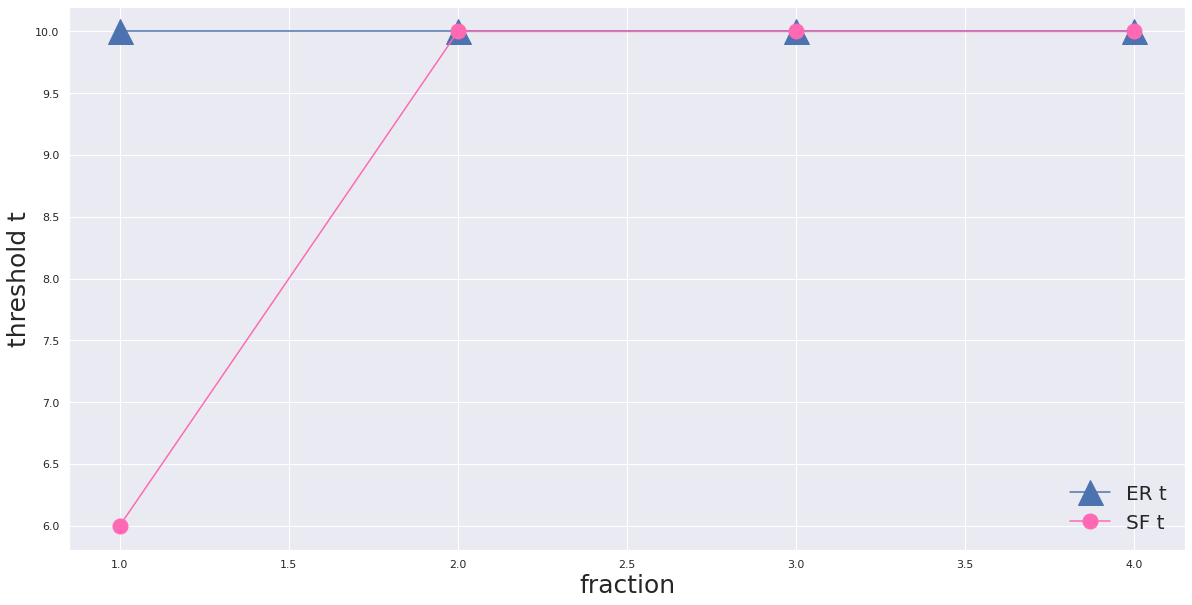

In [1419]:
#THRESHOLD t PLOTS
x = np.array([1,2,3,4])
t_ER = np.asarray(t_ER)

t_SF=np.asarray(t_SF)

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(x,t_ER,marker='^',color='b',linestyle = 'solid',markersize=25)
ax.plot(x,t_SF, marker='o', color='hotpink',linestyle = 'solid',markersize=15)

ax.legend(labels=['ER t', 'SF t'],fontsize=20,loc='best')
ax.set_ylabel('threshold t',fontsize=25)
ax.set_xlabel('fraction',fontsize=25)
plt.show()

ER graph thresholds stay the same for all graphs. But for SF graphs it shows increasing order. According to graphs ER and SF concordant with plots above. As S decreases and t shows increasing trends, SF increases and stays stable. As S decreases and t shows constant trends, ER stays the same.

Add your written answers here